## Author
Jarosław Wełeszczuk

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = "1"
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt 

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer

import seaborn as sns

import xgboost as xgb

In [4]:
caly_df=pd.read_csv('Prepared_geko_data.csv',sep=';')

In [5]:
caly_df

,time,temperatur,Sleep poze,Sleep position,splashing reaction,splashing reaction 2,touch reaction,behaviour on hand,after putting away,SPz | S shape,...,TR | runs,TR | moves,BoH | no movement,BoH | runs,BoH | jumps,BoH | moves,ApA | runs,ApA | hides,ApA | moves,ApA | stayes in place
0,10,23,straight,in the hideout,No Movement,does not licks,No Movement,No Movement,stays in place,0,...,0,0,1,0,0,0,0,0,0,1
1,10,23,U shape,in the hideout,moves the head,does not licks,Runs,Runs,stays in place,0,...,1,0,0,1,0,0,0,0,0,1
2,10,23,active,active,No Movement,does not licks,No Movement,jumps,Runs,0,...,0,0,0,0,1,0,1,0,0,0
3,10,23,active,active,moves,licks,Runs,Runs,Runs,0,...,1,0,0,1,0,0,1,0,0,0
4,10,23,straight,in the hideout,moves the head,licks,Runs,No Movement,stays in place,0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,16,26,straight,on coconut,moves the head,licks,No Movement,Runs,stays in place,0,...,0,0,0,1,0,0,0,0,0,1
2063,16,26,straight,back wall,moves the head,does not licks,No Movement,jumps,stays in place,0,...,0,0,0,0,1,0,0,0,0,1
2064,16,26,active,active,moves,licks,moves,Runs,moves,0,...,0,1,0,1,0,0,0,0,1,0
2065,16,26,active,active,moves,licks,moves,moves,moves,0,...,0,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

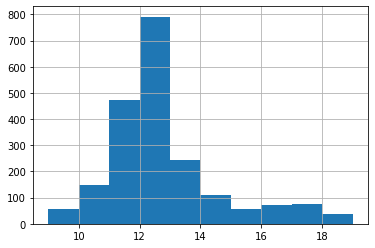

In [6]:
caly_df['time'].hist()

<AxesSubplot:>

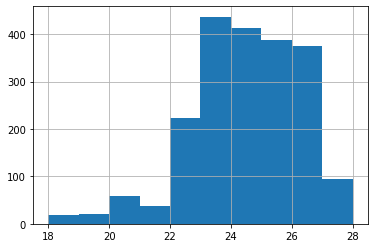

In [7]:
caly_df['temperatur'].hist()

In [8]:
caly_label=caly_df['touch reaction']

In [9]:
del caly_df['Sleep poze']
del caly_df['Sleep position']
del caly_df['splashing reaction']
del caly_df['splashing reaction 2']
del caly_df['touch reaction']
del caly_df['behaviour on hand']
del caly_df['after putting away']

In [10]:
del caly_df['TR | no movement']
del caly_df['TR | runs']
del caly_df['TR | moves']

In [11]:
caly_label=caly_label.astype('category')

In [12]:
decode_dict= dict(enumerate(caly_label.cat.categories))

In [13]:
caly_label=caly_label.cat.codes

In [14]:
caly_label

0       0
1       1
2       0
3       1
4       1
       ..
2062    0
2063    0
2064    2
2065    2
2066    2
Length: 2067, dtype: int8

In [15]:
caly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   time                   2067 non-null   int64
 1   temperatur             2067 non-null   int64
 2   SPz | S shape          2067 non-null   int64
 3   SPz | U shape          2067 non-null   int64
 4   SPz | active           2067 non-null   int64
 5   SPz | straight         2067 non-null   int64
 6   SPs | active           2067 non-null   int64
 7   SPs | back wall        2067 non-null   int64
 8   SPs | front wall       2067 non-null   int64
 9   SPs | in the hideout   2067 non-null   int64
 10  SPs | left wall        2067 non-null   int64
 11  SPs | on coconut       2067 non-null   int64
 12  SPs | right wall       2067 non-null   int64
 13  SR | no movement       2067 non-null   int64
 14  SR | moves             2067 non-null   int64
 15  SR | moves the head    2067 non-null  

In [14]:
param_grid={'booster':['gbtree'],
            'seed':[42],
            'nthread':[1],
            'objective':['softmax'],
            'use_label_encoder':[False],
            'eval_metric':['merror'],
            'n_estimators':[100],
            'eta': [0.3], #tree
            'max_depth': [10],#[6,10,14], #tree
            'subsample': [0.5,0.7,1], #tree
            'colsample_bytree': [0.5,0.7,1], #tree
            'colsample_bylevel': [0.5,0.7,1], #tree
            'colsample_bynode' : [0.5,0.7,1], #tree
            'gamma': [0],#[0,0.1,0.2], #tree
            'min_child_weight':[1],#[0.2,0.6,1], #tree
            'max_delta_step':[0.2,0.6,1], #tree
            'sampling_method':['uniform'], #tree
            'lambda':[0.8,1,1.2], #tree
            'alpha':[0,0.2,0.4], #tree
}

In [16]:
f1 = make_scorer(f1_score , average='macro')

In [16]:
dt_1 = xgb.XGBClassifier(random_state=42,nthread =1)

grid_search_1 = GridSearchCV(estimator = dt_1, param_grid = param_grid, 
                          cv = 2, n_jobs = 7, verbose = 1, scoring=f1)
grid_search_1.fit(caly_df, np.ravel(caly_label))

Fitting 2 folds for each of 2187 candidates, totalling 4374 fits


D:\anaconda\envs\notebook2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'colsample_bytree': [0.5, 0.7, 1], 'eta': [0.3],
                         'eval_metric': ['merror'], 'gamma': [0],
                         'lambda': [0.8, 1, 1.2],
                         'max_delta_step': [0.2, 0.6, 1], 'max_depth': [10],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'nthread': [1], 'objective': ['softmax'],
                         'sampling_method': ['uniform'], 'seed': [42],
                         'subsample': [0.5, 0.7, 1],
                         'use_label_encoder': [False]},
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [17]:
grid_search_1.best_score_ 

0.3910459262783765

In [18]:
grid_search_1.best_estimator_

XGBClassifier(alpha=0.2, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='merror', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.8, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.2, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [19]:
grid_search_1.best_params_

{'alpha': 0.2,
 'booster': 'gbtree',
 'colsample_bylevel': 0.5,
 'colsample_bynode': 0.5,
 'colsample_bytree': 0.5,
 'eta': 0.3,
 'eval_metric': 'merror',
 'gamma': 0,
 'lambda': 0.8,
 'max_delta_step': 0.2,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'softmax',
 'sampling_method': 'uniform',
 'seed': 42,
 'subsample': 0.5,
 'use_label_encoder': False}

In [19]:
param_grid={'booster':['gbtree'],
            'seed':[42],
            'nthread':[1],
            'objective':['softmax'],
            'use_label_encoder':[False],
            'eval_metric':['merror'],
            'n_estimators':[100],
            'eta': [0.3], #tree
            'max_depth': [6,10,14], #tree
            'subsample': [0.1,0.3,0.5], #tree  -tbd
            'colsample_bytree': [0.1,0.3,0.5], #tree
            'colsample_bylevel': [0.1,0.3,0.5], #tree
            'colsample_bynode' : [0.1,0.3,0.5], #tree
            'gamma': [0],#[0,0.1,0.2], #tree -tbd
            'min_child_weight':[1],#[0.2,0.6,1], #tree -tbd
            'max_delta_step':[0.1,0.2], #tree
            'sampling_method':['uniform'], #tree
            'lambda':[0.4,0.6, 0.8], #tree -tbd
            'alpha':[0.1,0.2,0.3], #tree -tbd
}

In [20]:
dt_1 = xgb.XGBClassifier(random_state=42,nthread =1)

grid_search_1 = GridSearchCV(estimator = dt_1, param_grid = param_grid, 
                          cv = 2, n_jobs = 7, verbose = 1, scoring=f1)
grid_search_1.fit(caly_df, np.ravel(caly_label))

Fitting 2 folds for each of 4374 candidates, totalling 8748 fits


D:\anaconda\envs\notebook2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'colsample_bytree': [0.1, 0.3, 0.5], 'eta': [0.3],
                         'eval_metric': ['merror'], 'gamma': [0],
                         'lambda': [0.4, 0.6, 0.8],
                         'max_delta_step': [0.1, 0.2], 'max_depth': [6, 10, 14],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'nthread': [1], 'objective': ['softmax'],
                         'sampling_method': ['uniform'], 'seed': [42],
                         'subsample': [0.1, 0.3, 0.5],
                         'use_label_encoder': [False]},
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [21]:
grid_search_1.best_score_

0.42541725580655787

In [22]:
grid_search_1.best_estimator_

XGBClassifier(alpha=0.3, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=0.1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='merror', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.4, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.2, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [23]:
grid_search_1.best_params_

{'alpha': 0.3,
 'booster': 'gbtree',
 'colsample_bylevel': 0.3,
 'colsample_bynode': 0.1,
 'colsample_bytree': 0.5,
 'eta': 0.3,
 'eval_metric': 'merror',
 'gamma': 0,
 'lambda': 0.4,
 'max_delta_step': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'softmax',
 'sampling_method': 'uniform',
 'seed': 42,
 'subsample': 0.5,
 'use_label_encoder': False}

In [24]:
param_grid={'booster':['gbtree'],
            'seed':[42],
            'nthread':[1],
            'objective':['softmax'],
            'use_label_encoder':[False],
            'eval_metric':['merror'],
            'n_estimators':[100],
            'eta': [0.1,0.3,0.5], #tree
            'max_depth': [4,6,8], #tree
            'subsample': [0.5,0.7,0.9], #tree  -tbd
            'colsample_bytree': [0.4,0.5,0.6], #tree
            'colsample_bylevel': [0.2,0.3,0.4], #tree
            'colsample_bynode' : [0.1,0.2], #tree
            'gamma': [0,0.3,0.5], #tree -tbd
            'min_child_weight':[0.2,0.6,1], #tree -tbd
            'max_delta_step':[0.2], #tree
            'sampling_method':['uniform'], #tree
            'lambda':[0.3,0.4,0.5], #tree -tbd
            'alpha':[0.3,0.4], #tree -tbd
}

In [25]:
dt_1 = xgb.XGBClassifier(random_state=42,nthread =1)

grid_search_1 = GridSearchCV(estimator = dt_1, param_grid = param_grid, 
                          cv = 2, n_jobs = 5, verbose = 1, scoring=f1)
grid_search_1.fit(caly_df, np.ravel(caly_label))

Fitting 2 folds for each of 26244 candidates, totalling 52488 fits


D:\anaconda\envs\notebook2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'eta': [0.1, 0.3, 0.5], 'eval_metric': ['merror'],
                         'gamma': [0, 0.3, 0.5], 'lambda': [0.3, 0.4, 0.5],
                         'max_delta_step': [0.2], 'max_depth': [4, 6, 8],
                         'min_child_weight': [0.2, 0.6, 1],
                         'n_estimators': [100], 'nthread': [1],
                         'objective': ['softmax'],
                         'sampling_method': ['uniform'], 'seed': [42],
                         'subsample': [0.5, 0.7, 0.9],
                         'use_label_encoder': [False]},
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [29]:
grid_search_1.best_score_

0.42743631631422974

In [30]:
grid_search_1.best_estimator_

XGBClassifier(alpha=0.3, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=0.1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='merror', feature_types=None, gamma=0.5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.5, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.2, max_depth=6, max_leaves=None,
              min_child_weight=0.2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [31]:
grid_search_1.best_params_

{'alpha': 0.3,
 'booster': 'gbtree',
 'colsample_bylevel': 0.3,
 'colsample_bynode': 0.1,
 'colsample_bytree': 0.5,
 'eta': 0.3,
 'eval_metric': 'merror',
 'gamma': 0.5,
 'lambda': 0.5,
 'max_delta_step': 0.2,
 'max_depth': 6,
 'min_child_weight': 0.2,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'softmax',
 'sampling_method': 'uniform',
 'seed': 42,
 'subsample': 0.5,
 'use_label_encoder': False}

In [33]:
param_grid={'booster':['gbtree'],
            'seed':[42],
            'nthread':[1],
            'objective':['softmax'],
            'use_label_encoder':[False],
            'eval_metric':['merror'],
            'n_estimators':[100],
            'eta': [0.2,0.3,0.4], #tree
            'max_depth': [5,6,7], #tree
            'subsample': [0.3,0.4,0.5,0.6], #tree  -tbd
            'colsample_bytree': [0.5], #tree
            'colsample_bylevel': [0.3], #tree
            'colsample_bynode' : [0.1], #tree
            'gamma': [0.4,0.5,0.6,0.7,0.8], #tree -tbd
            'min_child_weight':[0.1,0.2,0.3], #tree -tbd
            'max_delta_step':[0.2], #tree
            'sampling_method':['uniform'], #tree
            'lambda':[0.5,0.6,0.7,0.8], #tree -tbd
            'alpha':[0.3], #tree -tbd
}

In [34]:
dt_1 = xgb.XGBClassifier(random_state=42,nthread =1)

grid_search_1 = GridSearchCV(estimator = dt_1, param_grid = param_grid, 
                          cv = 2, n_jobs = 5, verbose = 1, scoring=f1)
grid_search_1.fit(caly_df, np.ravel(caly_label))

Fitting 2 folds for each of 2160 candidates, totalling 4320 fits


D:\anaconda\envs\notebook2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                         'eval_metric': ['merror'],
                         'gamma': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'lambda': [0.5, 0.6, 0.7, 0.8],
                         'max_delta_step': [0.2], 'max_depth': [5, 6, 7],
                         'min_child_weight': [0.1, 0.2, 0.3],
                         'n_estimators': [100], 'nthread': [1],
                         'objective': ['softmax'],
                         'sampling_method': ['uniform'], 'seed': [42],
                         'subsample': [0.3, 0.4, 0.5, 0.6],
                         'use_label_encoder': [False]},
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [35]:
grid_search_1.best_score_

0.4282619653708067

In [36]:
grid_search_1.best_estimator_

XGBClassifier(alpha=0.3, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=0.1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='merror', feature_types=None, gamma=0.7, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.8, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.2, max_depth=7, max_leaves=None,
              min_child_weight=0.2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [55]:
kfold = KFold(n_splits=5, shuffle=False)
dane_do_zapisu_1=pd.DataFrame()
licznik=1
wart_1=[]

for train, test in kfold.split(caly_df, caly_label):
    
    RF_1 =xgb.XGBClassifier(alpha=0.3, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=0.1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='merror', feature_types=None, gamma=0.7, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, reg_lambda=0.8, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.2, max_depth=7, max_leaves=None,
              min_child_weight=0.2,  monotone_constraints=None,
              n_estimators=100,)
    
    RF_1.fit(caly_df.iloc[train],
             caly_label.iloc[train])
    predykcje=RF_1.predict(caly_df.iloc[test])
    dane_folda_1=pd.DataFrame({"pred": predykcje.ravel(),
                                "obs": caly_label.iloc[test],
                                "Fold":licznik})
    dane_do_zapisu_1=pd.concat([dane_do_zapisu_1,dane_folda_1])
    
    sredni_blad=f1_score(caly_label.iloc[test], predykcje, average='macro')
    wart_1.append(sredni_blad)
    licznik+=1

In [56]:
wart_1

[0.41422690633216946,
 0.4549885643135902,
 0.41390130162059985,
 0.3684310957389996,
 0.44135382633963766]

In [57]:
sum(wart_1)/len(wart_1)

0.4185803388689993

In [58]:
confusion_matrix(dane_do_zapisu_1['obs'], dane_do_zapisu_1['pred'], labels=list(pd.unique(caly_label)))

array([[618, 220,  43],
       [287, 415,  64],
       [187, 188,  45]], dtype=int64)

In [59]:
class_names = RF_1.classes_


In [60]:
cf_matrix=confusion_matrix(dane_do_zapisu_1[dane_do_zapisu_1['Fold']==5]['obs'],
                           dane_do_zapisu_1[dane_do_zapisu_1['Fold']==5]['pred'],
                           labels=class_names)

In [61]:
class_names_2=[]
for x in class_names:
        class_names_2.append(decode_dict[x])

Text(0.5, 1.0, 'XGB Booster - touch reaction v_2')

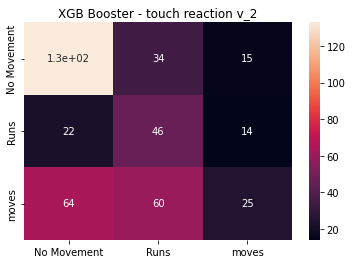

In [62]:
x_axis_labels = class_names_2
y_axis_labels = class_names_2

# create seabvorn heatmap with required labels
ax=sns.heatmap(cf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True)
ax.set_title('XGB Booster - touch reaction v_2')

In [54]:
dane_do_zapisu_1.to_csv('Geko_XGB__touch reaction.csv',sep=',')